In [1]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import math, random

In [34]:
# extracts the dataset from the csv file
# splits the dataset into the training and testing set
# takes in the filename of the csv file, the name of the labels,
#and the amount of the dataset that the model will have access to

def prepare_data(filename, label, proportion):
  df = pd.read_csv(filename)

  
  #throw out a portion of the dataset
  df, df_ = train_test_split(df, test_size = 1-proportion)
  
  #split data into training and testing set
  train, test = train_test_split(df, test_size = 0.2)

  #normalize the features and labels 
  train = (train - train.mean())/train.std()
  test = (test - test.mean())/test.std()

  #extract the labels and features 
  ytrain = train[label]
  ytest = test[label]

  train = train.drop(label, axis = 1)
  test = test.drop(label, axis = 1)

  xtrain = train
  xtest = test

  return xtrain, ytrain, xtest, ytest


#uses the weights of the model to estimate
#the labels as a linear combination of the feature
#values

def predict(weights, features):
  predictions = []

  
  #for each data point
  for i in range(len(features)):
    #use the weights to predict the label value
    predictions.append(weights[0] + np.dot(np.transpose(weights[1:]), np.transpose(features[i])))

  return predictions

#this function computes the fitness score of the model
#which is the MSE
#takes in the weights of the model, the feature set and the labels

def fitness(weights, features, labels):
  
  featMat = features.to_numpy()

  MSE = 0
  #get the predictions from the model
  predictions = predict(np.asarray(weights), featMat)

  targets = labels.to_numpy()

  
  #compute MSE
  for index in range(len(predictions)):
    MSE += (predictions[index] - targets[index])**2
  
  return MSE/len(predictions)





In [3]:
#this function performs crossover and mutation to generate children 
#models from parentA and parentB

def generateChildren(parentA, parentB, mutateRate):
  #child1 and 2's weights are chosen randomly from either parentA or parentB
  child1 = [ parentA[index] if random.random() < 0.5 else parentB[index] for index in range(len(parentA))]
  child2 = [ parentA[index] if random.random() < 0.5 else parentB[index] for index in range(len(parentA))]
  
  #and then for the mutation, we add a little bit of 0 mean gaussian noise
  #with variance given by mutateRate
  child1 = [x + np.random.normal(loc = 0, scale = mutateRate, size = 1) for x in child1]
  child2 = [x + np.random.normal(loc = 0, scale = mutateRate, size = 1) for x in child2]

  return child1, child2


#create a solution class which will hold the weights
#of the model, how old the model is,
#and the fitness score of the model
class solution:
  def __init__(self, weights, age, score):
    self.weights = weights
    self.age = age
    self.score = score
  
#create the new generation from the old
#takes in the old generation, list of solution objects,
#the feature set, labels, mutation rate, and age limit
#and returns a list of solution objects which represents the 
#new generation
def generate(oldGen, features, labels, mutateRate, age):
  newGen = oldGen


  numAdd = math.floor(len(oldGen) / 4)

  for count in range(numAdd):
    #to make a new child
    #we randomly sample 5 models from the old generation
    selection  = random.sample(oldGen, 5)

    #take the most fit one to get parentA
    parentA = min(selection, key = lambda x: x.score)
    
    #do the same to get parentB
    selection  = random.sample(oldGen, 5)
    
    parentB = min(selection, key = lambda x: x.score)

    #and have them breed together to make child1 and 2
    child1, child2 = generateChildren(parentA.weights, parentB.weights, mutateRate)

    #and then we add those children to the new generation
    newGen.append(solution(child1, -1, fitness(child1, features, labels)))
    newGen.append(solution(child2, -1, fitness(child2, features, labels)))
  

  #after that, we take out all of the models that are above the age limit
  newGen.sort(key = lambda x: x.age)


  index = 0
  #this part could be done more efficient using a slightly modified version binary search
  #but since we're already sorting the list by age we already have an NlogN operation going
  #on so doing a binary search wouldn't improve the performance by much
  while(index < len(newGen) and newGen[index] != age):
    index += 1
  

  newGen = newGen[0:index - 1]

  #then increment every model's age by 1
  for individual in newGen:
    individual.age += 1
  
  return newGen





In [32]:
#here we run the algorithm
#this function takes in the training set, the number of generations
#to run the algorithm for, the mutation rate, and the age limit
#returns the most fit model of the latest generation

def simulate(features, labels, numGen, mutationRate, age):
  
  population = []

  #first we fill up our population with models that have randomly chosen weights
  #since everything in the dataset has been normalized, it made sense to also have the 
  #weights also come from a guassian distribution with 0 mean and unit variance

  for perm in range(len(features.columns)*10):
    individual = [np.random.normal(loc = 0, scale = 1) for i in range(len(features.columns) + 1)]
    population.append(solution(individual, 0, fitness(individual, features, labels)))

  #for each generation, we replace the old generation with the new
  for iter in range(numGen):
    population = generate(population, features, labels, mutationRate, age)
  
  #and then we take the most fit member of the newest generation
  best = min(population, key = lambda x: x.score)

  
  return best.weights, best.score




In [43]:
#get the training and testing sets from the california housing dataset
xtrain, ytrain, xtest, ytest = prepare_data("california_housing.csv", 
                                                "Housevalue", 0.99)
#run the algorithm for 5 generations, with a mutation rate of 0.1, and 
#an age limit of 3. I didn't put that much thought into choosing these values
#but we could choose them by creating a validation set and find them using a
#genetic algorithm. So it would be like a GA where the population is a list of
#algorithms with different parameters. Even with this though it would still take
#probably take a long time so I won't do that.

model = simulate(xtrain, ytrain, 5, 0.1, 3)

#As can be seen below, the GA produced a model that achieved an MSE of
#0.52 which is significantly better than the benchmark MSE in which we just
#take the average of all the labels in the training set and use that for our prediction

baseError = mean_squared_error(ytest, [ytrain.mean()]*len(ytest))
print("The baseline MSE for the california housing dataset is: " + str(baseError) +"\n")


print("On the other hand, the model produced by the genetic algorithm" + 
      " achieved a mean squared error of " + 
      str(fitness(model[0], xtest, ytest)[0]) + "\n on the testing set!")


The baseline MSE for the california housing dataset is: 0.9997553217518965

On the other hand, the model produced by the genetic algorithm achieved a mean squared error of 0.5908872089388948
 on the testing set!


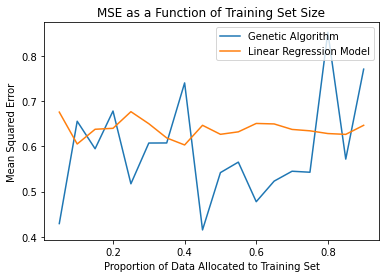

In [41]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

#I wanted to see performance of the GA as a function of the size of the 
#training set and compare it to the performance of the linear regression
#model. 

#As can be seen below, the GA regression model generally outperforms the 
#linear regression model and maintains a low MSE value even when there is a
#very small amount of training data

#However, it looks like the linear regression model's MSE is almost constant 
#which is pretty amazing. This is likely due to the california housing dataset
#being too easy since then the models would easily be able to figure out the 
#relationship between the features and labels. A much harder dataset is needed
#to really see how the two models perform when there is a small amount of data
#available.

def dataPerformance():
  perfGA = []
  perfLM = []
  #we try out a range of different sizes for the training set
  for proportion in np.arange(0.05, 0.95, 0.05):
    #get the training and testing sets
    xtrain, ytrain, xtest, ytest = prepare_data("california_housing.csv", 
                                                "Housevalue", proportion)
    #then we get the MSE of the model produced by the GA
    #as well as the MSE from the linear model
    Perf = fitness(simulate(xtrain, ytrain, 5, 0.1, 3)[0], xtest, ytest)

    perfGA.append(Perf)
    reg = LinearRegression().fit(xtrain, ytrain)
    perfLM.append(reg.score(xtest, ytest))

  #then we plot the performance of the two algorithms as a function of the 
  #size of the training set
  plt.plot(np.arange(0.05, 0.95, 0.05), perfGA, label = "Genetic Algorithm")
  plt.plot(np.arange(0.05, 0.95, 0.05), perfLM, label = "Linear Regression Model")
  plt.xlabel("Proportion of Data Allocated to Training Set")
  plt.ylabel("Mean Squared Error")
  plt.title("MSE as a Function of Training Set Size")
  plt.legend(loc = "upper right")


dataPerformance()
